# **K-Nearest Neighbors Regression to predict banana fruit ripeness**

## Prerequisite

### Import Library

In [ ]:
import os
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preparation

### Load Data

In [2]:
sheet_id = "1N520L1iE9cw53y1UcBC3OqK03udjyeQVf2l18YQQWsU"
gid = "1719648740"

url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

df = pd.read_csv(url)
display(df.head())

,id,Column 1,r,g,b,tvoc,co2,timestamp,ripeness,nextPhase
0,NoSJvUrfcoDWISxk9cyK,1,111,187,97,89,653,2025-11-08T17:18:05.504+07:00,raw,1.25
1,3hHcToxTZTlfvhyj5XN6,2,116,182,97,90,656,2025-11-08T17:38:04.997+07:00,raw,1.00
2,CSUfD9zgyhVh9S0vgENw,3,111,188,97,93,647,2025-11-08T17:42:14.559+07:00,raw,1.25
3,4YBW5cHhpdmHZ90c4MLV,4,109,186,99,116,687,2025-11-08T17:45:28.646+07:00,raw,2.00
4,Kf4VEdxOmxcLVTLRgRuU,5,111,189,96,118,696,2025-11-08T17:55:51.915+07:00,raw,2.00


### Preprocessing

In [3]:
# Select relevant attributes (tambahkan r,g,b)
df = df[["tvoc", "co2", "r", "g", "b", "ripeness", "nextPhase"]]

# Imputation
df = df.fillna(df.mean(numeric_only=True))

# Encoding categorical column 'ripeness'
df = pd.get_dummies(df, columns=["ripeness"])

# Normalize numeric columns
for col in ["tvoc", "co2", "r", "g", "b"]:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

display(df.head())

,tvoc,co2,r,g,b,nextPhase,ripeness_raw,ripeness_ripe,ripeness_spoiled
0,0.009630,0.012983,0.484848,0.88,0.275862,1.25,True,False,False
1,0.010137,0.013407,0.636364,0.68,0.275862,1.00,True,False,False
2,0.011657,0.012137,0.484848,0.92,0.275862,1.25,True,False,False
3,0.023315,0.017782,0.424242,0.84,0.344828,2.00,True,False,False
4,0.024328,0.019052,0.484848,0.96,0.241379,2.00,True,False,False


### Split Data

In [4]:
# X = features (tvoc + ripeness encoded), y = target (nextPhase)
X = df.drop("nextPhase", axis=1).values
y = df["nextPhase"].values

# Define function to split data
def train_test_split(X, y, test_size=0.2, random_state=None):
    n = len(X)
    indices = np.arange(n)
    if random_state is not None:
        np.random.seed(random_state)
    np.random.shuffle(indices)
    
    split = int(n * (1 - test_size))
    train_idx, test_idx = indices[:split], indices[split:]
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensions of train data:", X_train.shape)
print("Dimensions of test data:", X_test.shape)

Dimensions of train data: (376, 8)
Dimensions of test data: (95, 8)


## Tuning

### Definition of KNN Core Functions

In [5]:
# KNN (regression) core functions
def euclidean_distance(x1, x2):
    """Calculate the Euclidean distance between two vectors"""
    return np.sqrt(np.sum((x1 - x2) ** 2))

def predict_knn(x_new, X_train, y_train, k):
    """Prediction of 1 new data with KNN regression"""
    distances = [euclidean_distance(x_new, x) for x in X_train]
    k_idx = np.argsort(distances)[:k]
    return np.mean(y_train[k_idx])   # regresi → rata-rata target tetangga

def evaluate_knn(X_val, y_val, X_train, y_train, k):
    """KNN evaluation for 1 value of k"""
    preds = [predict_knn(x, X_train, y_train, k) for x in X_val]
    
    mae = np.mean(np.abs(y_val - preds))
    rmse = np.sqrt(np.mean((y_val - preds) ** 2))
    ss_res = np.sum((y_val - preds) ** 2)
    ss_tot = np.sum((y_val - np.mean(y_val)) ** 2)
    r2 = 1 - ss_res/ss_tot
    
    return {"k": k, "MAE": mae, "RMSE": rmse, "R2": r2}

### Loop Tuning k

In [6]:
# Test the k value from 1 to 50
k_values = range(1, 51)
tuning_results = []

for k in k_values:
    result = evaluate_knn(X_test, y_test, X_train, y_train, k)
    tuning_results.append(result)

# Convert to DataFrame for analysis
results_df = pd.DataFrame(tuning_results)
results_df

,k,MAE,RMSE,R2
0,1,0.286842,0.503279,0.591450
1,2,0.273684,0.478828,0.630183
2,3,0.267544,0.453946,0.667619
3,4,0.247368,0.426603,0.706454
4,5,0.251579,0.418393,0.717644
5,6,0.242105,0.409946,0.728931
6,7,0.244737,0.409031,0.730138
7,8,0.238158,0.404564,0.736001
8,9,0.237719,0.402225,0.739044
9,10,0.238947,0.400772,0.740926


### Tuning Results Visualization

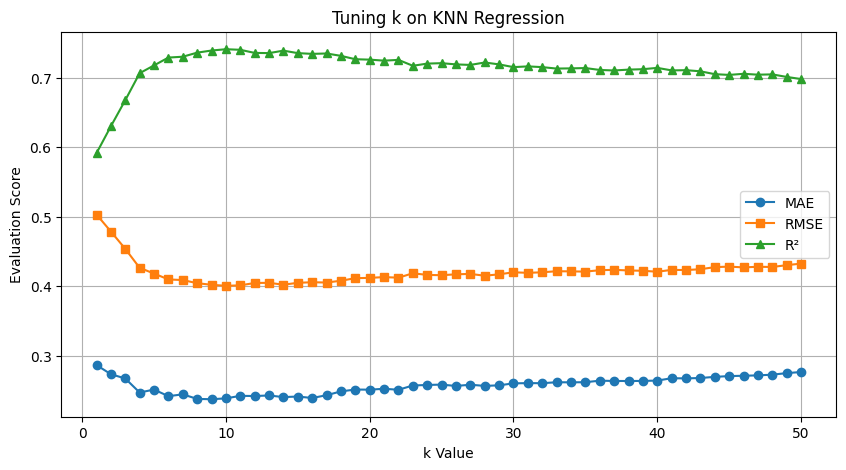

In [7]:
# Visualization of the performance of each k
plt.figure(figsize=(10, 5))
plt.plot(results_df["k"], results_df["MAE"], label="MAE", marker="o")
plt.plot(results_df["k"], results_df["RMSE"], label="RMSE", marker="s")
plt.plot(results_df["k"], results_df["R2"], label="R²", marker="^")
plt.xlabel("k Value")
plt.ylabel("Evaluation Score")
plt.title("Tuning k on KNN Regression")
plt.legend()
plt.grid(True)
plt.show()

### Select k Optimal

In [8]:
# Choose k with the smallest RMSE
best_row = results_df.loc[results_df["RMSE"].idxmin()]
best_k = int(best_row["k"])

print("k optimal:", best_k)
print("Best evaluation score:")
print(best_row)

k optimal: 10
Best evaluation score:
k       10.000000
MAE      0.238947
RMSE     0.400772
R2       0.740926
Name: 9, dtype: float64


### Final Evaluation

In [9]:
# Finalization of the KNN model with the best k
model_config = {
    "k": best_k,
    "X_train": X_train.tolist(),
    "y_train": y_train.tolist()
}

## Testing

### Define test function in Python with JS flow

In [ ]:
def predict_knn_js(tvoc, co2, r, g, b, ripeness, X_train, y_train, k):
    ripeness_map = {
        "raw": [1,0,0],
        "ripe": [0,1,0],
        "spoiled": [0,0,1]
    }
    if ripeness not in ripeness_map:
        raise ValueError("Invalid ripeness")
    
    x_input = np.array([tvoc, co2, r, g, b] + ripeness_map[ripeness])
    
    distances = [np.sqrt(np.sum((x - x_input)**2)) for x in X_train]
    k_idx = np.argsort(distances)[:k]
    return np.mean(y_train[k_idx])


## Test model

In [ ]:
preds = []
for i in range(len(X_train)):
    tvoc, co2, r, g, b, raw, ripe, spoiled = X_train[i]
    ripeness = "raw" if raw==1 else "ripe" if ripe==1 else "spoiled"
    pred = predict_knn_js(tvoc, co2, r, g, b, ripeness, X_train, y_train, best_k)
    preds.append(pred)

print("Contoh prediksi:", preds[:10])


## Deployment

### Save Config File

In [10]:
def save_model_to_json(model_config, filename="../../backend/services/prediction/knn_model_config.json"):
    """Save the KNN model configuration to a JSON file, creating folder if needed."""
    try:
        # Make sure the destination folder exists
        folder = os.path.dirname(filename)
        os.makedirs(folder, exist_ok=True)

        # Save file
        with open(filename, "w") as f:
            json.dump(model_config, f, indent=2)
        print(f"Model configuration successfully saved to '{filename}'")
    except Exception as e:
        print("Failed to save model:", e)

# Save model
save_model_to_json(model_config)

Model configuration successfully saved to '../../backend/services/prediction/knn_model_config.json'
